In [107]:
## jupyter notebook to simulate the range of the nuclear recoils in a given decay chain

import numpy as np
import matplotlib.pyplot as plt
import alpha_recoil_sim as ar
import importlib
from scipy.interpolate import CubicSpline

In [119]:
importlib.reload(ar)

## make dictionary containing decay chain information for a given list of isotopes
path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC"

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']

iso_dict = {}

for iso in iso_list:
    ciso = iso[:2].lower()
    cA = iso[-3:]
    iso_dict[iso] = ar.parse_decay_chain(path + "/decay_data/" + ciso + "_" + cA + "_decay_chain.txt")

In [120]:
## Load the Monte Carlo data from SRIM
import pickle

data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

with open(data_path + 'SRIM_MC_events.pkl', 'rb') as f:
    MC_dict = pickle.load(f)

In [121]:
### load the ESTAR data and make a dictionary with interpolation functions
matlist = ['SiO2', 'Au', 'Ag', 'tissue'] ## materials to use
matdensity = [2.0, 19.31, 10.47, 1.05] ## densities in g/cm^3
beta_dict = {}

MeV_to_keV = 1000
cm_to_nm = 1e7

for dens,mat in zip(matdensity, matlist):

    estar_data = np.loadtxt(path + "/decay_data/" + mat.lower() + '_estar.txt', skiprows=2)
    interp_func = CubicSpline(estar_data[:,0]*MeV_to_keV, estar_data[:,3]*MeV_to_keV*dens/cm_to_nm)

    beta_dict[mat] = interp_func ## interpolation function taking energy in keV and returning energy loss in keV/nm

In [126]:
## Run over the isotopes and various shell materials, and save data
importlib.reload(ar)

iso_list = ['Ac-225'] #['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [350, 100, 150]
N = 10 ##20000

out_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

sim_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        print("Working on %d events for %s with %s shell"%(N, iso, shell))

        sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

        sim_dict[iso + "_" + shell] = ar.sim_N_events(N, iso, iso_dict, sphere_dict, MC_dict, beta_dict=beta_dict,
                                                      exterior_mat='tissue', simulate_alpha=True, simulate_beta=True)

with open(data_path + 'simulation_data.pkl', 'wb') as f:
    pickle.dump(sim_dict, f)

Working on 10 events for Ac-225 with SiO2 shell
MC iteration:  0  of  10
Number of steps:  349
Number of steps:  58
Number of steps:  201
Number of steps:  57
Number of steps:  127
Number of steps:  75
Number of steps:  119
Number of steps:  70
Number of steps:  398
Number of steps:  12
Number of steps:  115
Number of steps:  58
Number of steps:  13
Number of steps:  89
Number of steps:  175
Number of steps:  90
Number of steps:  76
Number of steps:  12
Number of steps:  140
Number of steps:  157
Working on 10 events for Ac-225 with Au shell
MC iteration:  0  of  10
Number of steps:  18
Number of steps:  35
Number of steps:  75
Number of steps:  114
Number of steps:  329
Number of steps:  39
Number of steps:  135
Number of steps:  107
Number of steps:  187
Number of steps:  43
Number of steps:  47
Number of steps:  48
Number of steps:  170
Number of steps:  44
Number of steps:  82
Number of steps:  455
Number of steps:  95
Working on 10 events for Ac-225 with Ag shell
MC iteration:  0 

In [52]:
with open(data_path + 'simulation_data.pkl', 'rb') as f:
    sim_dict = pickle.load(f)

In [37]:
sim_dict['Ac-225_SiO2'][0][0]['traj_alpha']

array([[ 5.83000000e+03,  4.55262115e+00, -1.01539939e+01,
         3.78804429e+00],
       [ 5.81110000e+03, -2.41626776e+01,  7.07371739e-01,
         2.54264678e+01],
       [ 5.81110000e+03, -2.41626776e+01,  7.07371739e-01,
         2.54264678e+01],
       [ 5.73990000e+03, -1.47450242e+02,  4.73400508e+01,
         1.18329855e+02],
       [ 5.66190000e+03, -2.92491343e+02,  1.02130503e+02,
         2.28165499e+02],
       [ 5.66190000e+03, -2.92491343e+02,  1.02130503e+02,
         2.28165499e+02],
       [ 5.60100000e+03, -4.12405639e+02,  1.47429101e+02,
         3.18973302e+02],
       [ 5.53410000e+03, -5.54539930e+02,  2.00791328e+02,
         4.26542540e+02],
       [ 5.47670000e+03, -6.95248364e+02,  2.53510884e+02,
         5.32848124e+02],
       [ 5.41830000e+03, -8.35213386e+02,  3.05957537e+02,
         6.38540885e+02],
       [ 5.35130000e+03, -9.74158302e+02,  3.57875574e+02,
         7.44112508e+02],
       [ 5.28100000e+03, -1.11159499e+03,  4.09172327e+02,
      

Found 0 bad points out of 10: 0.000%
Found 0 bad points out of 10: 0.000%
Found 0 bad points out of 10: 0.000%


KeyError: 'Pb-212_SiO2'

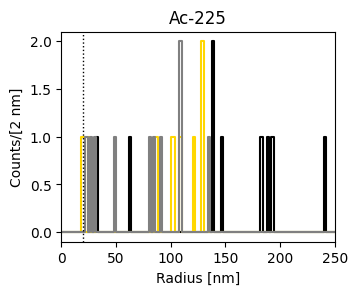

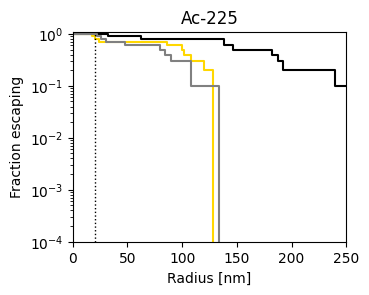

In [131]:
iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [350, 100, 150]


# Make a plot of the final position distribution and escape fraction for each isotope
col_list = ['k', 'gold', 'gray']
importlib.reload(ar)

thresh_list = [0.5, 0.1, 0.01, 0.001]
sty = ['-', '--', ':']

fig_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/plots/'

df = plt.figure(facecolor='white', figsize=(12,6))
sf = plt.figure(facecolor='white', figsize=(12,6))
idx = 1

thickness_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

        x, y, s = ar.analyze_simulation( sim_dict[iso + "_" + shell] )
        plt.figure(df.number)
        plt.subplot(2,3,idx)
        plt.step(x,y,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Counts/[2 nm]")
        plt.xlim(0,250)

        plt.figure(sf.number)
        plt.subplot(2,3,idx)
        plt.step(x,s,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Fraction escaping")
        plt.xlim(0,250)

        thick = np.interp(thresh_list, s[::-1], x[::-1])
        thickness_dict[iso + "_" + shell] = thick

    plt.figure(df.number)
    yy = plt.ylim()
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    plt.figure(sf.number)
    plt.gca().set_yscale('log')
    yy = [1e-4, 1.1]
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    idx +=1

plt.figure(df.number)
#df.subplots_adjust(hspace=0.4)
leg=plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "range_vs_iso.pdf")

plt.figure(sf.number)
#sf.subplots_adjust(hspace=0.4)
leg = plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "escape_vs_iso.pdf")


KeyError: 'At-211_SiO2'

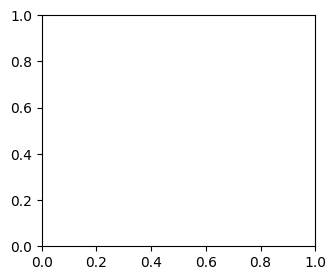

In [132]:
## plot fraction escaping versus iso and thickness

plt.figure(facecolor='white', figsize=(12,3))

iso_list = ['At-211', 'Pb-212', 'Ra-223', 'Ac-225', 'Th-227']

cmap = plt.get_cmap('Blues_r')
n=6
colors = [cmap(i/(n-1)) for i in range(n)] 

rin = sphere_dict['inner_radius']

for j,shell in enumerate(shell_mat):
    
    plt.subplot(1,3,j+1)

    thick_dat = []
    for iso in iso_list:
        
        cdat = thickness_dict[iso + "_" + shell]

        thick_dat.append(cdat)

    thick_dat = np.array(thick_dat)
    for k in range(np.shape(thick_dat)[1]):
        plt.plot( thick_dat[:,k]-rin, '-o', color=colors[k], label="%g%%"%(thresh_list[k]*100))
    yy = plt.ylim()
    plt.ylim([0,yy[1]])
    ax = plt.gca()
    ax.set_xticks(range(len(iso_list)))
    ax.set_xticklabels(iso_list)
    plt.ylabel("Shell thickness [nm]")

    if(j == 0):
        [plt.legend()]

    plt.grid(True)

    plt.title(shell)
    plt.tight_layout()
    plt.savefig(fig_path + "shell_vs_escape.pdf")

Found 14 bad points out of 20000: 0.070%


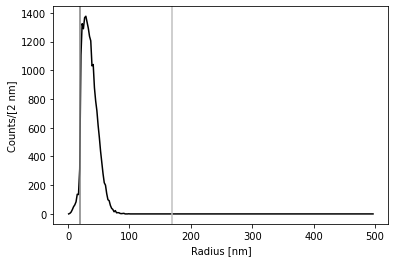

In [5]:
importlib.reload(ar)
ar.analyze_simulation(sim_dict['Ac-225_Au'], sphere_dict)

[[8.044960069835017, 31.382306889616984], [-6.161082086826334, 16.533284649310136], [-20.10885253838755, 26.003010611605028]]


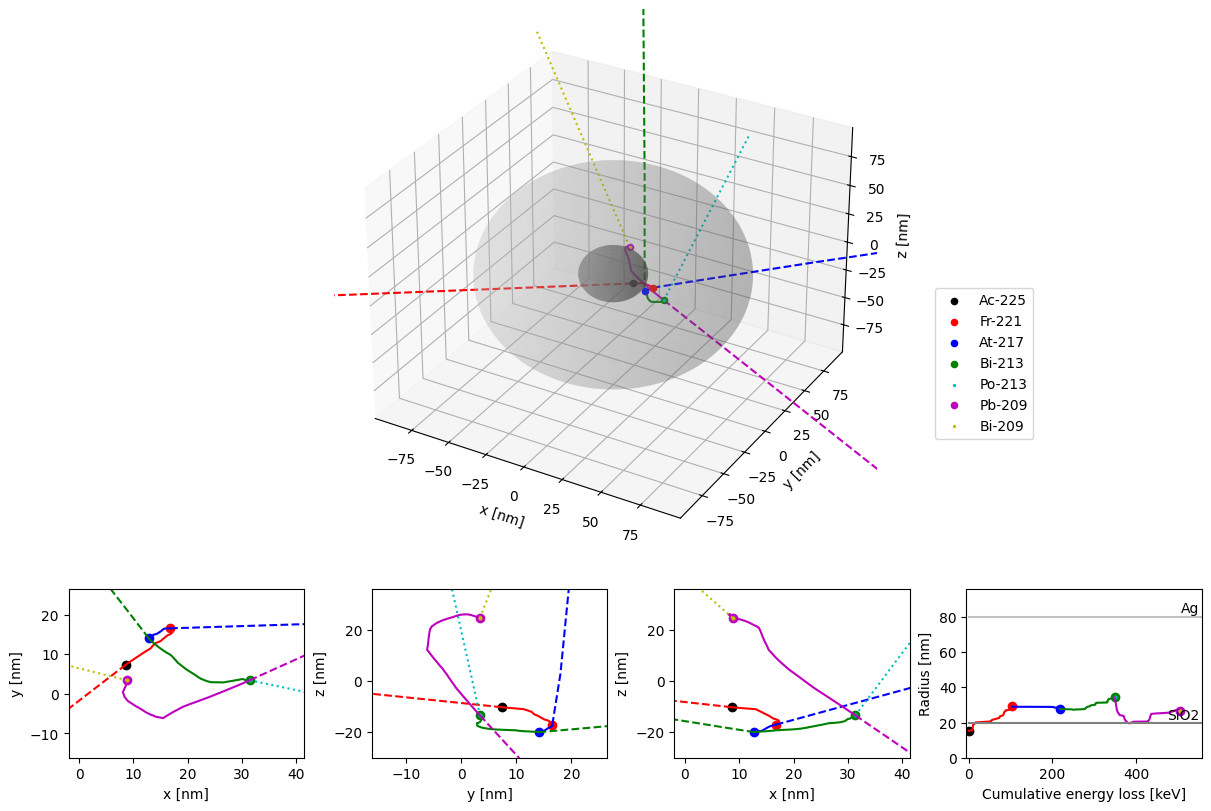

In [130]:
importlib.reload(ar)

iso = "Ac-225"
shell = "Ag"
num = 1

shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [350, 100, 150]

sphere_dict['shell_material'] = shell
sphere_dict['outer_shell_thick'] = 60

plt.close('all')
fig = ar.plot_event(sim_dict[iso + "_" + shell][num], sphere_dict, plot_alphas=True, plot_betas=True)
#plt.savefig(fig_path + "examp_traj_%s_%s_%d.png"%(iso, shell, num), dpi=300)

plt.show()